In [82]:
import sys
from pathlib import Path

import pandas as pd
import geopandas as gpd

import folium
from folium.plugins import HeatMap
from shapely.geometry import Point
from IPython.display import IFrame, display

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid", palette="viridis")

sys.path.append(str(Path().resolve().parent / "src"))
from utils import load_all_csvs
from sanitize import sanitize_all

In [2]:
dfs = load_all_csvs(Path.cwd().parent / "data")
dfs = sanitize_all(dfs)

In [3]:
dfs['geocode'].head()

,Unnamed: 0,Lab Id,Address,Location,Zipcode
0,0,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096
1,1,L520,"1614 N JAMES ST, ROME, NY 13440","43.2311327,-75.4445363",13440
2,2,L141,"12911 120TH AVE NE STE D60, KIRKLAND, WA 98034","47.7162786,-122.1838152",98034
3,3,L524,"5667 PEACHTREE DUNWOODY RD 250, ATLANTA, GA 30342","33.9093875,-84.3529096",30342
4,4,L545,"1204 IL HWY 164, OQUAWKA, IL 61469","40.9309925,-90.9437598",61469


In [4]:
dfs['transactional'].head()

,Patient Id,Gender,Date of birth,Date of service,Service Id,Lab Id,CodItem,Testing Cost
0,10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70003237,9.0
1,10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70000638,13.0
2,10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70001597,49.0
3,10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70000103,11.0
4,10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70000224,10.0


In [5]:
# Padroniza os zipcodes
dfs['geocode']['Zipcode'] = dfs['geocode']['Zipcode'].astype(str).str.split('.').str[0].str.zfill(5)

# Merge para adicionar ZCTA ao dataset de exames
dfs['transactional'] = dfs['transactional'].merge(dfs['geocode'][['Lab Id', 'Zipcode']], on='Lab Id', how='left')
dfs['transactional'].rename(columns={'Zipcode': 'ZCTA'}, inplace=True)

# Converte a coluna de data
dfs['transactional']['Date of service'] = pd.to_datetime(dfs['transactional']['Date of service'], errors='coerce')

dfs['transactional'][['Date of service', 'ZCTA']].head()

,Date of service,ZCTA
0,2019-01-07,94565
1,2019-01-07,94565
2,2019-01-07,94565
3,2019-01-07,94565
4,2019-01-07,94565


In [9]:
# Data mais recente do dataset
data_max = dfs['transactional']['Date of service'].max()
print(f"Última data disponível: {data_max.date()}")

# Define o limite inferior
data_limite = data_max - pd.DateOffset(years=1)
df_recent = dfs['transactional'][dfs['transactional']['Date of service'] >= data_limite].copy()

# Agrupa por ZCTA
df_exames_recentes = df_recent.groupby('ZCTA').size().reset_index(name='num_exames_recentes')

df_exames_recentes.sort_values(by='num_exames_recentes', ascending=False).head(10)

Última data disponível: 2021-02-12


,ZCTA,num_exames_recentes
82,94565,25156
88,95823,18008
52,30096,17599
90,98008,16941
40,19143,14038
94,98034,13597
43,19148,13324
53,30135,13176
89,98004,12976
37,19120,12748


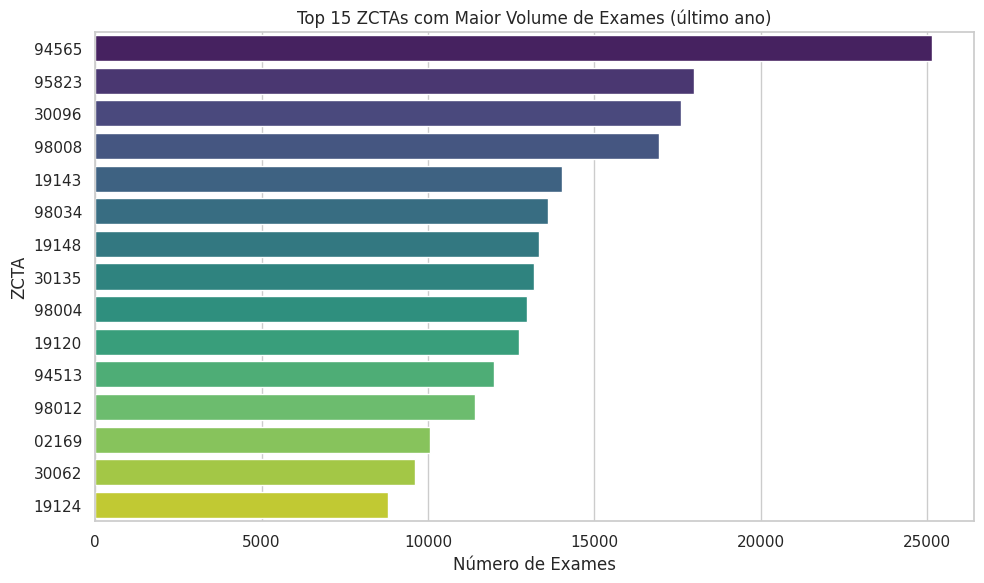

In [14]:
# Seleciona os top 15 ZCTAs com mais exames
top_zctas = df_exames_recentes.sort_values(by='num_exames_recentes', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_zctas,
    x='num_exames_recentes',
    y='ZCTA',
    hue='ZCTA',
    palette='viridis',
    legend=False
)
plt.title('Top 15 ZCTAs com Maior Volume de Exames (último ano)')
plt.xlabel('Número de Exames')
plt.ylabel('ZCTA')
plt.tight_layout()
plt.show()

In [13]:
if 'ZCTA' not in dfs['demographic'].columns:
    dfs['demographic']['ZCTA'] = dfs['demographic']['GeographicAreaName'].str.extract(r'ZCTA5 (\d{5})')[0]

# Merge dos exames recentes com dados demográficos
h2a_df = df_exames_recentes.merge(
    dfs['demographic'][['ZCTA', 'TotalPopulation', 'MedianAgeInYears']],
    on='ZCTA',
    how='left'
)

# Visualiza os principais
h2a_df.sort_values(by='num_exames_recentes', ascending=False).head(10)

,ZCTA,num_exames_recentes,TotalPopulation,MedianAgeInYears
82,94565,25156,97671.0,34.1
88,95823,18008,79440.0,31.4
52,30096,17599,68691.0,35.8
90,98008,16941,25719.0,42.3
40,19143,14038,64630.0,32.9
94,98034,13597,43471.0,36.8
43,19148,13324,52259.0,36.4
53,30135,13176,67710.0,37.7
89,98004,12976,36202.0,37.8
37,19120,12748,74060.0,30.2


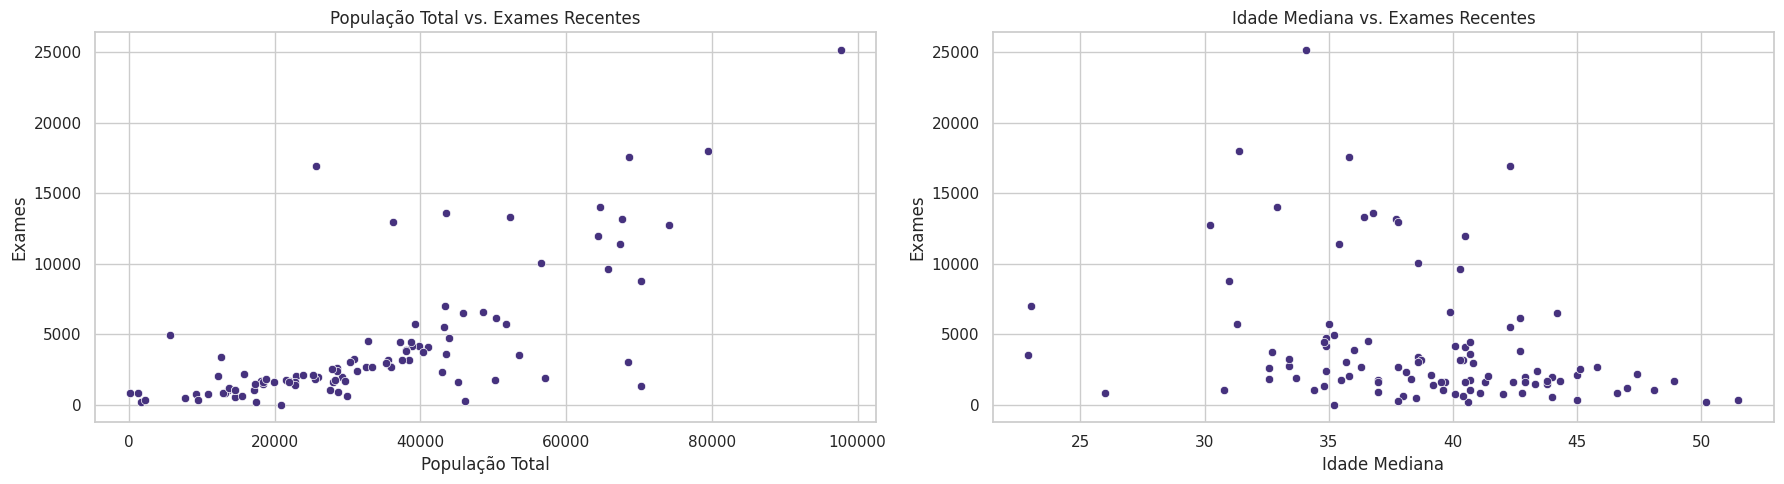

In [18]:
# Remove possíveis nulos
h2a_df = h2a_df.dropna(subset=['TotalPopulation', 'MedianAgeInYears', 'num_exames_recentes'])

# Criação dos plots
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.scatterplot(data=h2a_df, x='TotalPopulation', y='num_exames_recentes', ax=axes[0])
axes[0].set_title('População Total vs. Exames Recentes')
axes[0].set_xlabel('População Total')
axes[0].set_ylabel('Exames')

sns.scatterplot(data=h2a_df, x='MedianAgeInYears', y='num_exames_recentes', ax=axes[1])
axes[1].set_title('Idade Mediana vs. Exames Recentes')
axes[1].set_xlabel('Idade Mediana')
axes[1].set_ylabel('Exames')

plt.tight_layout()
plt.show()


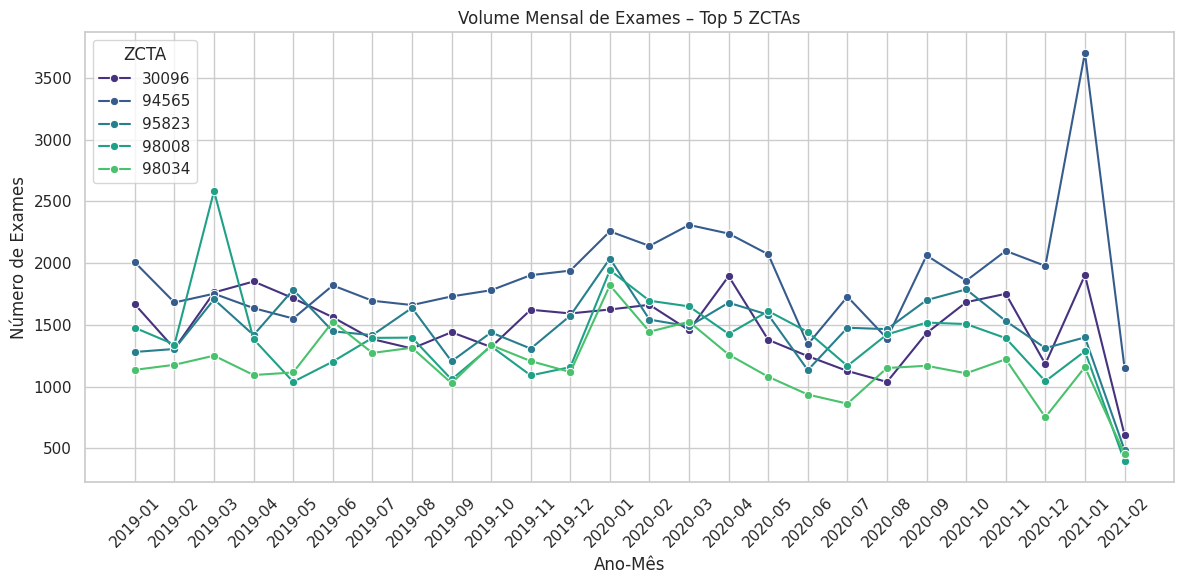

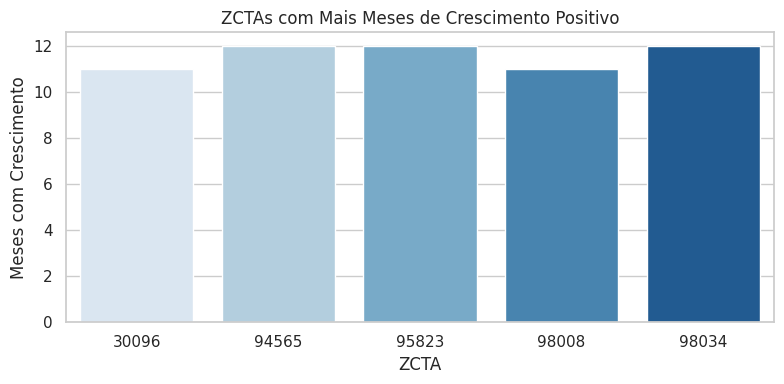

In [91]:
# Extrai ano-mês
dfs['transactional']['YearMonth'] = dfs['transactional']['Date of service'].dt.to_period('M').astype(str)

# Agrupa por ZCTA e mês
df_series = dfs['transactional'].groupby(['YearMonth', 'ZCTA']).size().reset_index(name='num_exames')

# Seleciona os Top 5 ZCTAs com maior volume total
top_zctas = (
    df_series.groupby('ZCTA')['num_exames'].sum()
    .sort_values(ascending=False).head(5).index.tolist()
)

# Filtra somente esses ZCTAs
df_top_series = df_series[df_series['ZCTA'].isin(top_zctas)]

# 📈 Gráfico 1 – Série temporal mensal
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_top_series, x='YearMonth', y='num_exames', hue='ZCTA', marker='o')
plt.title('Volume Mensal de Exames – Top 5 ZCTAs')
plt.xlabel('Ano-Mês')
plt.ylabel('Número de Exames')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 📊 Gráfico 2 – Crescimento entre os dois últimos meses

# Reordena a série por ZCTA e mês
df_sorted = df_top_series.sort_values(['ZCTA', 'YearMonth'])

# Calcula a diferença mês a mês
df_sorted['crescimento'] = df_sorted.groupby('ZCTA')['num_exames'].diff()

# Conta quantos meses tiveram crescimento positivo por ZCTA
crescimento_consistente = df_sorted.groupby('ZCTA')['crescimento'].apply(lambda x: (x > 0).sum()).reset_index()
crescimento_consistente.columns = ['ZCTA', 'meses_com_crescimento']

plt.figure(figsize=(8, 4))
sns.barplot(data=crescimento_consistente, x='ZCTA', hue='ZCTA', y='meses_com_crescimento', palette='Blues')
plt.title('ZCTAs com Mais Meses de Crescimento Positivo')
plt.xlabel('ZCTA')
plt.ylabel('Meses com Crescimento')
plt.tight_layout()
plt.show()

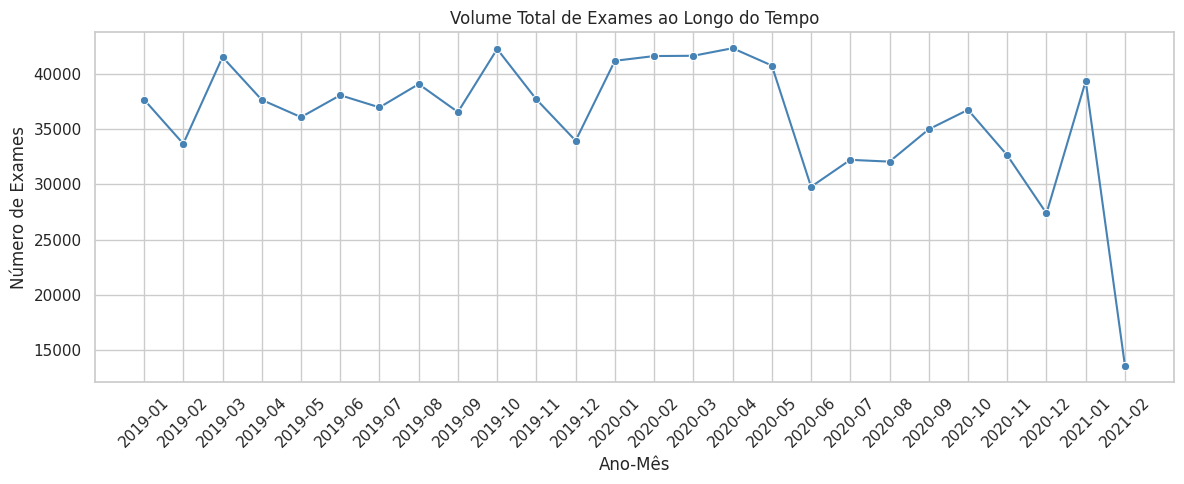

In [22]:
# Agrupa por mês e soma exames
df_global_series = dfs['transactional'].groupby('YearMonth').size().reset_index(name='num_exames')

# Ordena datas corretamente
df_global_series = df_global_series.sort_values(by='YearMonth')

plt.figure(figsize=(12, 5))
sns.lineplot(data=df_global_series, x='YearMonth', y='num_exames', marker='o', color='steelblue')
plt.title('Volume Total de Exames ao Longo do Tempo')
plt.xlabel('Ano-Mês')
plt.ylabel('Número de Exames')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 📊 H2a – ZCTAs com Maior Volume de Exames Indicam Maior Potencial Futuro

A análise temporal dos dados demonstra que:

- Os principais ZCTAs (como 94565, 95823 e 30096) mantêm volume elevado e relativamente estável ao longo do tempo.
- O volume total da rede foi consistente até o início da pandemia, com queda temporária e posterior retomada.
- Esses comportamentos reforçam a hipótese de que **ZCTAs com histórico de alta demanda** representam **potencial futuro promissor**, principalmente quando combinados com características demográficas favoráveis.
- Além disso, a análise de tendência mostrou que esses mesmos ZCTAs também apresentam **mais meses com crescimento positivo no número de exames realizados**, evidenciando um **crescimento progressivo e consistente ao longo do tempo**.

> **Conclusão**: H2a é **fortemente suportada** pelos dados históricos, tanto em nível local (ZCTA) quanto geral. A **combinação entre volume elevado e trajetória de crescimento contínuo** posiciona essas regiões como áreas de **prioridade estratégica para investimentos e expansão operacional**.


In [33]:
zcta_gdf = gpd.read_file("../data/zcta_subset.geojson")

In [63]:
# Contagem de exames por ZCTA
df_exames_por_zcta = dfs['transactional'].groupby('ZCTA').size().reset_index(name='num_exames')

# Top 15 ZCTAs com mais exames
top_zctas = (
    df_exames_por_zcta.sort_values(by='num_exames', ascending=False)
    .head(30)
)

# Conta labs por ZCTA
labs_por_zcta = dfs['geocode'].groupby('Zipcode').size().reset_index(name='num_labs')

# Merge com top_zctas
top_zctas_df = top_zctas.merge(labs_por_zcta, left_on='ZCTA', right_on='Zipcode', how='left')
top_zctas_df['num_labs'] = top_zctas_df['num_labs'].fillna(0).astype(int)

# Filtra geometria só das top ZCTAs
top15_geo = zcta_gdf[zcta_gdf['ZCTA5CE20'].isin(top_zctas_df['ZCTA'])].copy()

# Junta com num_labs
top15_geo = top15_geo.merge(
    top_zctas_df[['ZCTA', 'num_labs', 'num_exames']],
    left_on='ZCTA5CE20',
    right_on='ZCTA',
    how='left'
)

top_zctas_df.head()

,ZCTA,num_exames,Zipcode,num_labs
0,94565,49475,94565,1
1,30096,38511,30096,1
2,95823,38128,95823,1
3,98008,35935,98008,1
4,98034,30495,98034,3


In [64]:
# 1. Projeta para um CRS métrico adequado (ex: Albers USA)
top15_proj = top15_geo.to_crs(epsg=5070)

# 2. Calcula o centróide no sistema projetado
top15_proj['centroid'] = top15_proj.geometry.centroid

# 3. Transforma de volta para latitude/longitude (EPSG:4326)
top15_proj = top15_proj.set_geometry('centroid').to_crs(epsg=4326)

# 4. Extrai lat/lon
top15_geo['lat'] = top15_proj.geometry.y.values
top15_geo['lon'] = top15_proj.geometry.x.values

# Prepara dados para o HeatMap
heat_data = top15_geo[['lat', 'lon', 'num_exames']].dropna().values.tolist()

top15_geo_clean = top15_geo.drop(columns=['centroid', 'lat', 'lon'], errors='ignore')

m = folium.Map(location=[39.5, -98.35], zoom_start=4)

# Choropleth para apenas as 15 ZCTAs, colorindo por número de labs
folium.Choropleth(
    geo_data=top15_geo_clean.to_json(),
    name='Top 15 ZCTAs – Número de Laboratórios',
    data=top15_geo,
    columns=['ZCTA5CE20', 'num_labs'],
    key_on='feature.properties.ZCTA5CE20',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.3,
    legend_name='Número de Laboratórios'
).add_to(m)

HeatMap(heat_data, radius=25, blur=15, max_zoom=10).add_to(m)

# Tooltip opcional com número de exames
for _, row in top15_geo.iterrows():
    popup_text = f"ZCTA: {row['ZCTA5CE20']}<br>Exames: {row['num_exames']}<br>Labs: {row['num_labs']}"
    folium.GeoJson(
        row['geometry'],
        style_function=lambda x: {'color': 'black', 'weight': 1, 'fillOpacity': 0},
        tooltip=popup_text
    ).add_to(m)

m.save("../reports/top15_zctas_labs.html")

In [66]:
IFrame('../reports/top15_zctas_labs.html', width=900, height=600)

### 🌍 Análise Espacial – Top 15 ZCTAs com Maior Demanda de Exames

A visualização geoespacial combinando **Choropleth** e **Heatmap** revela padrões importantes para a expansão estratégica:

1. **Alta demanda em clusters específicos**  
   ZCTAs como `94565`, `19145`, `95823` e `30096` concentram uma quantidade elevada de exames, evidenciada pela densidade no heatmap.

2. **Desbalanceamento entre demanda e infraestrutura**  
   Alguns ZCTAs com volumes expressivos de exames possuem **apenas 1 ou nenhum laboratório**, indicando possíveis gargalos logísticos ou dependência de envio de amostras.

3. **Oportunidades de expansão física**  
   A análise identifica **ZCTAs com alta demanda mas baixa cobertura local** — o que pode orientar decisões sobre:
   - Implantação de novos pontos de coleta
   - Parcerias com clínicas locais
   - Estratégias logísticas de regionalização

4. **Complementaridade com dados demográficos**  
   A sobreposição dessa visualização com as análises H1 (população, idosos, perfil econômico) pode ajudar a **priorizar ZCTAs que reúnem demanda real + perfil-alvo**.

---

> 💡 Essa análise reforça a importância de integrar dados espaciais com inteligência operacional para **identificação de oportunidades** e **redução de ineficiências**.


### 📊 H2b – Exames com maior custo operacional estão associados a maior receita e lucro para a rede.

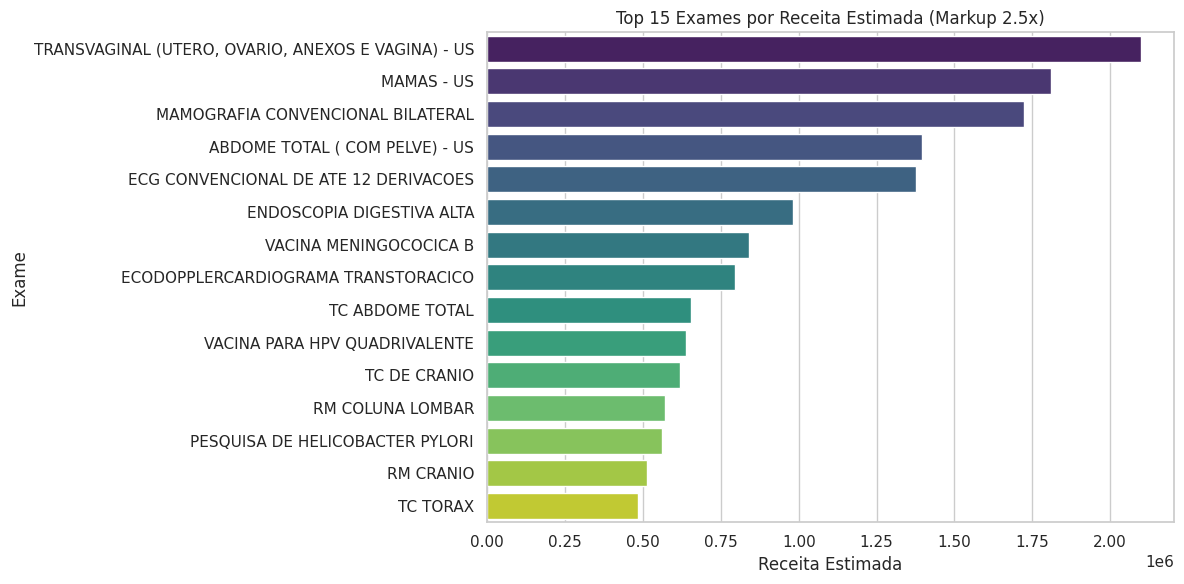

In [68]:
exam_freq = dfs['transactional'].groupby('CodItem').size().reset_index(name='num_exames')

exam_analysis = exam_freq.merge(dfs['exams'][['CodItem', 'Desc Item', 'Testing Cost']], on='CodItem', how='left')
exam_analysis['Testing Cost'] = exam_analysis['Testing Cost'].astype(str).str.replace(',', '.').astype(float)

# Estima preço cobrado com markup de 2.5x sobre o custo
exam_analysis['preco_estimado'] = exam_analysis['Testing Cost'] * 2.5

# Estima receita por tipo de exame
exam_analysis['receita_estimada'] = exam_analysis['preco_estimado'] * exam_analysis['num_exames']

# Ordena pelos exames com maior receita estimada
top_receita = exam_analysis.sort_values(by='receita_estimada', ascending=False).head(15)

plt.figure(figsize=(12, 6))
sns.barplot(data=top_receita, x='receita_estimada', y='Desc Item', hue='Desc Item', palette='viridis')
plt.title('Top 15 Exames por Receita Estimada (Markup 2.5x)')
plt.xlabel('Receita Estimada')
plt.ylabel('Exame')
plt.tight_layout()
plt.show()

## 💰 H2b – Receita Estimada por Exame

Como os dados de receita real não estavam disponíveis, adotamos uma abordagem alternativa:

#### ✅ Abordagem:
- Estimado o preço cobrado por exame com um **markup de 2.5x** sobre o custo operacional (`Testing Cost`)
- Calculado a **receita estimada total** por tipo de exame:  
  `receita_estimada = preço_estimado × número de exames`
- Visualizamos os **Top 15 exames por receita estimada**

#### 📊 Resultados:
- Os exames que lideram em receita estimada combinam:
  - **Alta demanda** (volume de execução elevado)
  - **Custo moderado a alto**
- Exames como:
  - **Ultrassonografia transvaginal**,  
  - **Mamografia**,  
  - **Endoscopia digestiva alta**  
  estão entre os mais lucrativos.
- Alguns exames de custo elevado (ex: ressonâncias, tomografias) aparecem no ranking, mas **em menor volume**.

#### 🧠 Conclusão:
> Exames com **custo operacional moderado a alto**, quando associados a **alta demanda**, são responsáveis por grande parte da receita estimada da rede.
>
> Essa análise **apoia parcialmente a hipótese original**: o custo contribui, mas o **fator decisivo é a frequência de realização**.

Essa visão pode ajudar a priorizar **portfólios de exames** em regiões estratégicas e **avaliar o impacto financeiro** de cada serviço oferecido.


In [86]:
# Estima proporção de mulheres com base na razão entre sexos
dfs['demographic']['perc_mulheres'] = 1 / (1 + (dfs['demographic']['SexRatio(males per 100 females)'] / 100))

# Marca quais ZCTAs têm laboratório
zctas_com_lab = dfs['geocode']['Zipcode'].unique()
dfs['demographic']['tem_lab'] = dfs['demographic']['ZCTA'].isin(zctas_com_lab)

# Junta com o número de exames por ZCTA
df_oportunidade = dfs['demographic'].merge(
    df_exames_por_zcta, on='ZCTA', how='left'
)

# Preenche ZCTAs sem exames com 0
df_oportunidade['num_exames'] = df_oportunidade['num_exames'].fillna(0)

# Filtra:
# - proporção de mulheres > 51%
# - ZCTAs com laboratório (obs: Nao existem ZCTAs majoritariamente femininas que nao possuem um laboratorio)
# - com pelo menos 500 exames
df_estrategico = df_oportunidade[
    (df_oportunidade['perc_mulheres'] > 0.51) &
    (df_oportunidade['tem_lab'] == True) &
    (df_oportunidade['num_exames'] > 500)
].copy()

# Visualização opcional: ordena por número de exames
display(df_estrategico[['ZCTA', 'perc_mulheres', 'num_exames']].sort_values(by='num_exames', ascending=False).head())

# Exibe resultado
df_estrategico[['ZCTA', 'perc_mulheres', 'num_exames']].sort_values(by='perc_mulheres', ascending=False).head()

,ZCTA,perc_mulheres,num_exames
5511,30096,0.529101,38511.0
3390,95823,0.514139,38128.0
25434,19120,0.524659,30405.0
5537,30135,0.519481,29867.0
25457,19143,0.554017,26890.0


,ZCTA,perc_mulheres,num_exames
25457,19143,0.554017,26890.0
25458,19144,0.554017,11850.0
12778,01950,0.544662,2727.0
25358,19004,0.543478,1663.0
19647,13088,0.542888,3826.0


## 📊 H2c - Análise Estratégica – ZCTAs com Predominância Feminina

**Hipótese**: ZCTAs com alta proporção de mulheres podem ser estratégicos para expansão, especialmente considerando que os exames mais rentáveis da rede são voltados à saúde feminina.

#### ✅ Abordagem:
- Estimado a proporção de mulheres por ZCTA a partir da razão entre sexos.
- Identificado ZCTAs:
  - Com **mais de 51% de população feminina**
  - Com **volume relevante de exames**
  - E **verificamos a presença de laboratórios**

#### 📊 Resultados:
- ZCTAs como `30096`, `95823`, `19120` e `30135`:
  - Têm alta demanda de exames
  - População majoritariamente feminina
  - E **já possuem laboratório local**
- **Não foram identificados ZCTAs com predominância feminina e volume elevado de exames que estejam completamente descobertos pela rede** (ou seja, **sem laboratório**).

#### 🧠 Conclusão:
> Ainda que não existam lacunas evidentes em cobertura para o público feminino, a análise reforça que ZCTAs com **alta concentração de mulheres** e **demanda significativa** são **áreas prioritárias para manutenção e fortalecimento da presença da rede** — inclusive para oferta e marketing de exames com alta rentabilidade voltados à saúde da mulher.

Essa visão complementa a hipótese H2b, mostrando que a **demanda qualificada por perfil populacional** pode contribuir para **aumentar o retorno dos serviços prestados**.
